In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

In [3]:
img1path = 'image1.tif'
img2path = 'image2.tif'


In [26]:
defaultargs={
    'sat_pix':.2,
    'contrast_adjust':.85,
    'clahe_size':90,
    'clahe_clip_limit':1.5,
    'sigma':2,
    'fill_with_noise':True
}
def filter_em_image(img,args=defaultargs):


        mask=np.array(img>0,np.uint8)
        #img = 255-img
        #f, ax = plt.subplots(1,1,figsize=(10,10))
        #ax.imshow(img,cmap=plt.cm.gray)
        sat_pix = args['sat_pix']/100

        hgram=cv2.calcHist([img],[0],mask,[256],[0,256])
        cum_dist = np.cumsum(hgram)/np.sum(hgram)
        min_level = np.where(np.diff(cum_dist>sat_pix)==1)[0][0]
        max_level = np.where(np.diff(cum_dist<(1.0-sat_pix))==1)[0][0]

        img = np.array(img,np.double)
        if (max_level==min_level):
            print 'min_level',min_level
            print 'max_level',max_level
            print 'on file',path_in
            raise Exception("%s %f %f"%(path_in,min_level,max_level))

        img = ((img-min_level)/(max_level-min_level))*255
        img = (img - 128)*args['contrast_adjust'] + 128
        #print 'img[2012,195]',img[2012,195]
        img = np.clip(img,0,255)
        #print 'img[2012,195]',img[2012,195]
        img = np.array(img,np.uint8)
        #print 'img[2012,195]',img[2012,195]
        img = cv2.GaussianBlur(img,(2*args['sigma']+1,2*args['sigma']+1),args['sigma'],args['sigma'])
        #img = cv2.bilateralFilter(img,5,20,20)
        #clahe1 = cv2.createCLAHE(clipLimit=.5, tileGridSize=(10,10))
        #grid_size = args['clahe_size']
        #clahe2 = cv2.createCLAHE(clipLimit=args['clahe_clip_limit'],
        #    tileGridSize=(grid_size,grid_size))
        #img = clahe1.apply(img)
        #img = clahe2.apply(img)
        return img

In [194]:
img1 = cv2.imread(img1path,cv2.CV_8UC1)
img2 = cv2.imread(img2path,cv2.CV_8UC1)
img1 = filter_em_image(img1,defaultargs)
img2 = filter_em_image(img2,defaultargs)

img1 = img1[0:1024,1024:]
img2 = img2[1024:,0:1024]
#img1 = cv2.resize(img1,(1024,512))
#img2 = cv2.resize(img2,(1024,1024))

In [195]:
orb=cv2.ORB_create(nfeatures=500)
blob_params = cv2.SimpleBlobDetector_Params()
blob_params.minThreshold=75
blob_params.maxThreshold=250
print blob_params.minArea
blob_params.minArea=400
blob_params.filterByColor=False
blob_params.filterByCircularity=False
blob_params.filterByInertia=False
blob_params.filterByConvexity=False
blob= cv2.SimpleBlobDetector_create(blob_params)

daisy = cv2.xfeatures2d.DAISY_create(radius=250,norm=cv2.xfeatures2d.DAISY_NRM_FULL, use_orientation=False)

25.0


In [262]:
def detect_kp_and_plot(detector,img,min_size=10):
    #img=filter_em_image(img)
    kps=detector.detect(img,None)
    f,ax = plt.subplots(1,1)
    ax.imshow(img,cmap=plt.cm.gray)
    kp_all=[]
    for kp in kps:
        if kp.size>min_size:
            kp.size*=1
            kp.angle=0
            circle = plt.Circle(kp.pt,kp.size,fill=False,edgecolor='r')
            ax.add_patch(circle)
            
            kp_all.append(kp)

    return kp_all

<IPython.core.display.Javascript object>


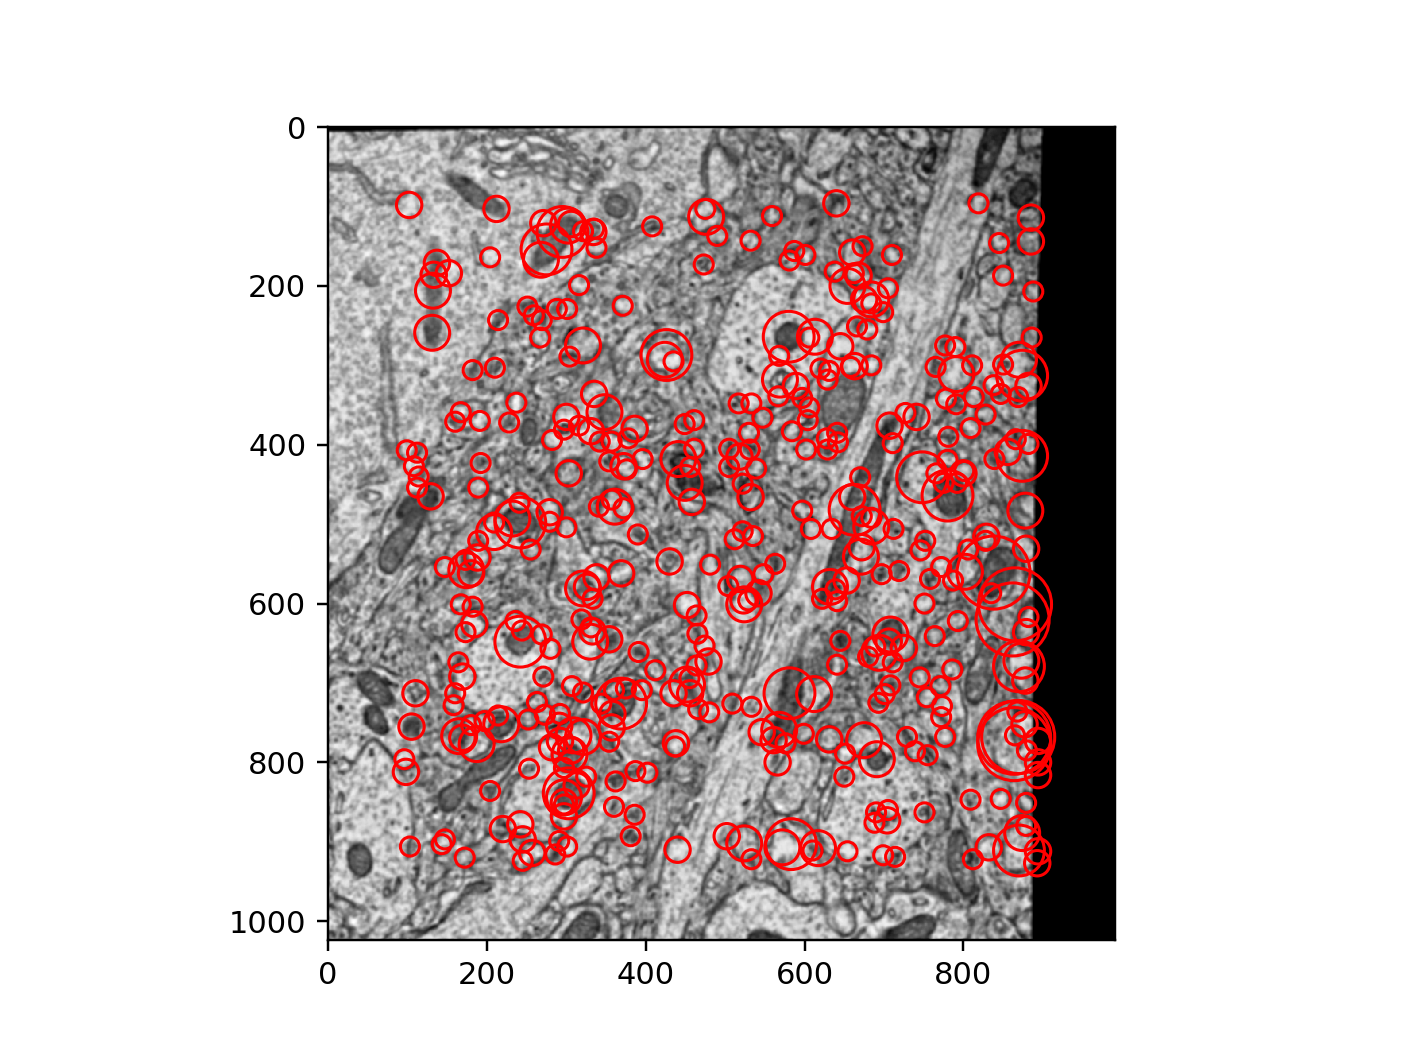

<IPython.core.display.Javascript object>


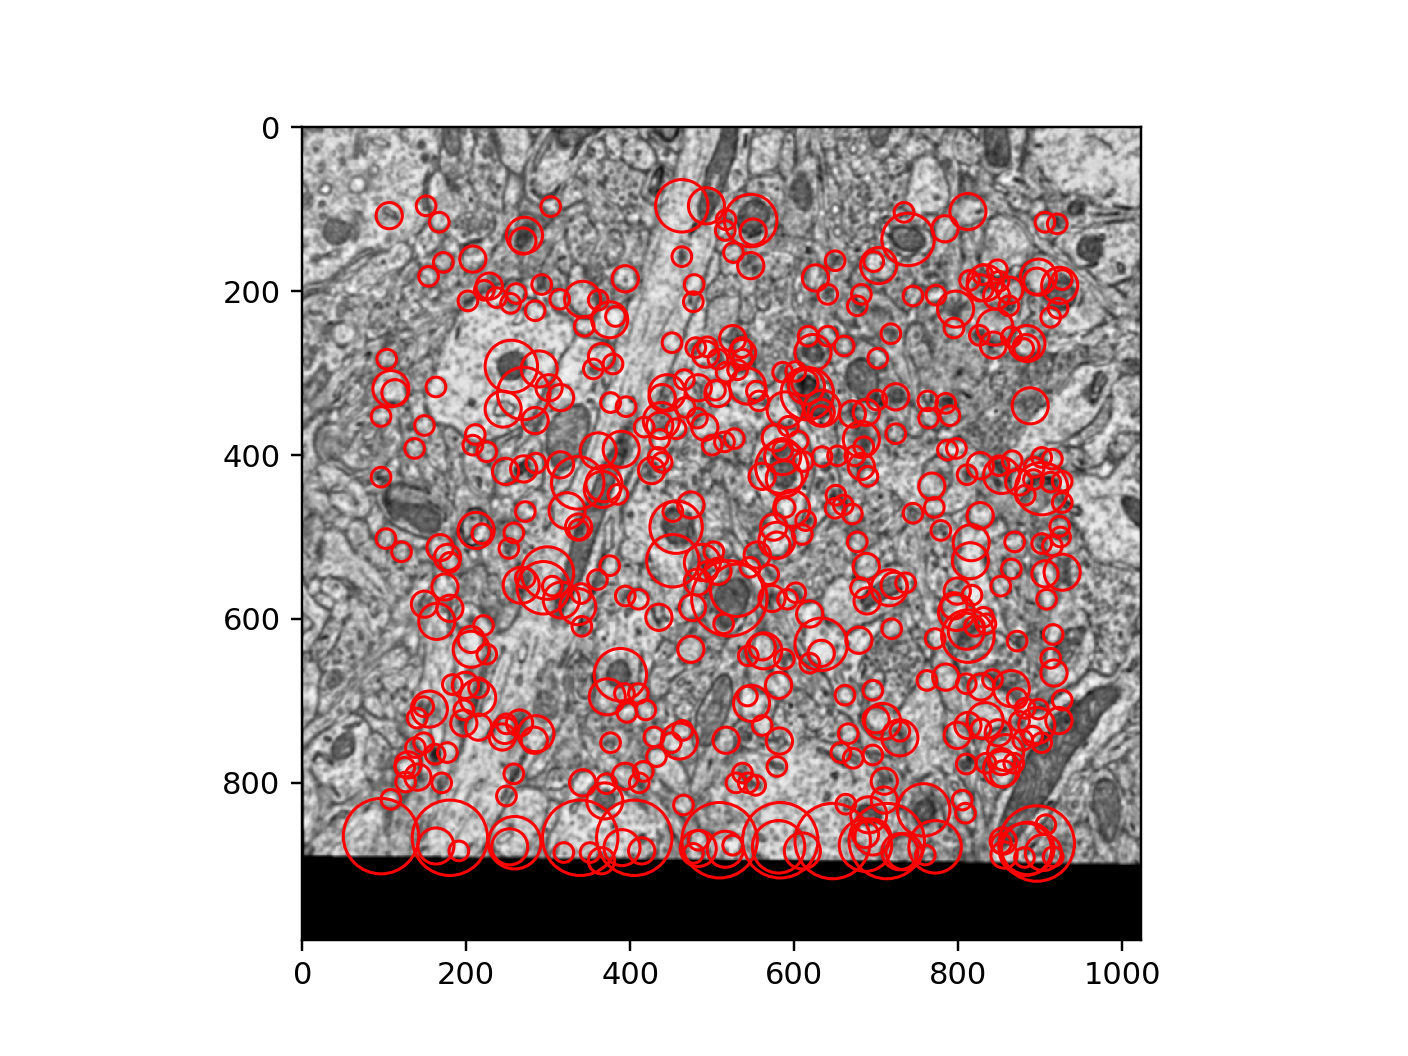

In [263]:
star=cv2.xfeatures2d.StarDetector_create(maxSize=50,responseThreshold=40)
kp1=detect_kp_and_plot(star,img1)
kp2=detect_kp_and_plot(star,img2)
# # for kp in kp1:
# #     kp.size*=5
# # for kp in kp2:
# #     kp.size*=5


In [246]:
surf=cv2.xfeatures2d.SURF_create()

In [247]:
kp1,desc1=surf.compute(img1,kp1)
kp2,desc2=surf.compute(img2,kp2)


In [248]:
cv2.xfeatures2d.SURF_create?

In [249]:
bfmatch=cv2.BFMatcher_create()

In [250]:
matches=np.array(bfmatch.match(queryDescriptors=desc2,trainDescriptors=desc1))

In [251]:
def draw_matches(img1, kp1, img2, kp2, matches, color=None): 
    """Draws lines between matching keypoints of two images.  
    Keypoints not in a matching pair are not drawn.

    Places the images side by side in a new image and draws circles 
    around each keypoint, with line segments connecting matching pairs.
    You can tweak the r, thickness, and figsize values as needed.

    Args:
        img1: An openCV image ndarray in a grayscale or color format.
        kp1: A list of cv2.KeyPoint objects for img1.
        img2: An openCV image ndarray of the same format and with the same 
        element type as img1.
        kp2: A list of cv2.KeyPoint objects for img2.
        matches: A list of DMatch objects whose trainIdx attribute refers to 
        img1 keypoints and whose queryIdx attribute refers to img2 keypoints.
        color: The color of the circles and connecting lines drawn on the images.  
        A 3-tuple for color images, a scalar for grayscale images.  If None, these
        values are randomly generated.  
    """
    # We're drawing them side by side.  Get dimensions accordingly.
    # Handle both color and grayscale images.
    f,ax = plt.subplots(1,1,figsize=(10,5))
    
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    ax.imshow(new_img,cmap=plt.cm.gray)
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    thickness = 2
    if color:
        c = color
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.queryIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        ax.plot([end1[0],end2[0]],[end1[1],end2[1]],linewidth= thickness)
        #cv2.circle(new_img, end1, r, c, thickness)
        #cv2.circle(new_img, end2, r, c, thickness)
    


<IPython.core.display.Javascript object>


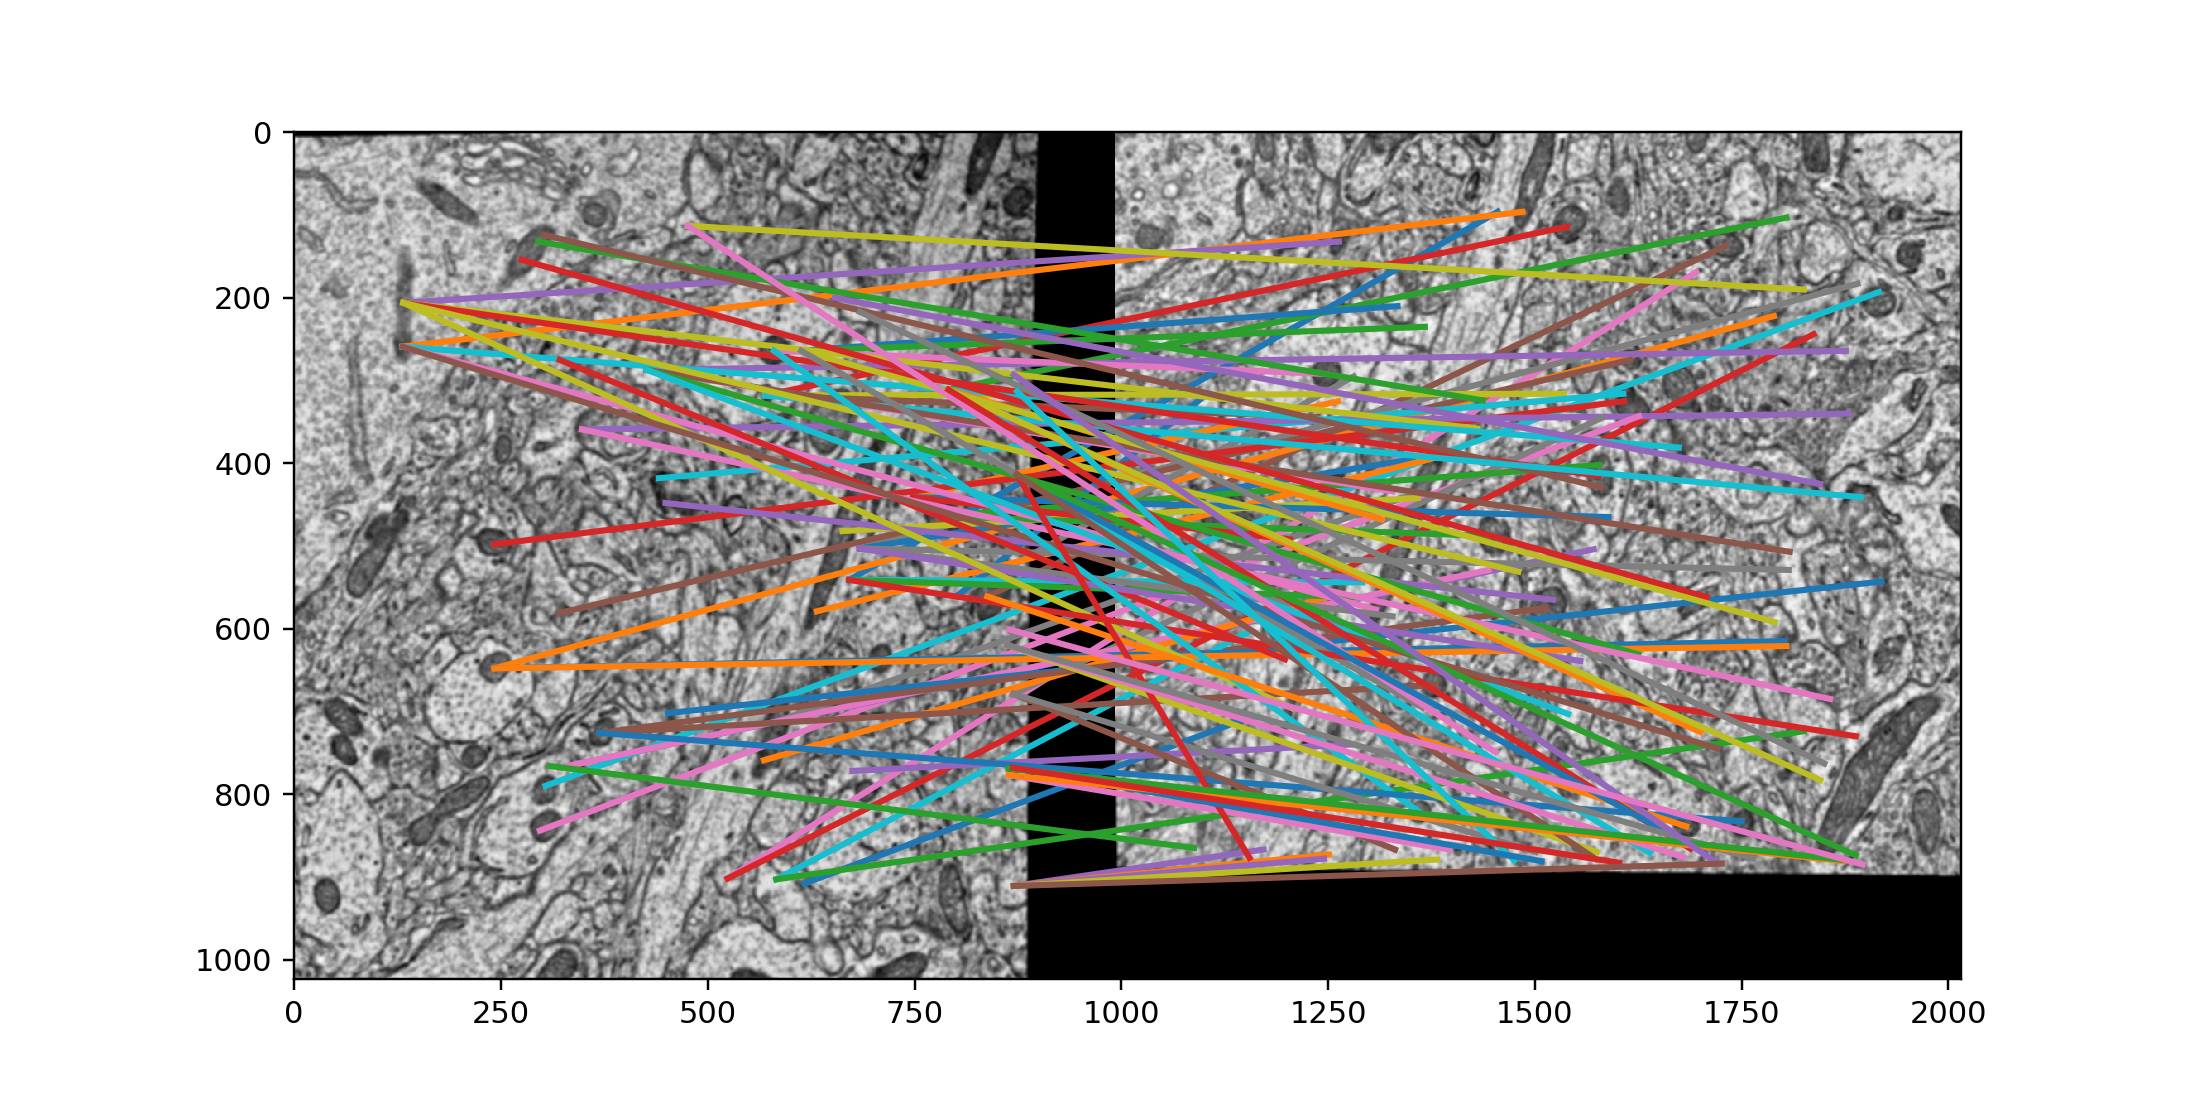

In [252]:
draw_matches(img1,kp1,img2,kp2,matches)

In [253]:
import ransac

In [258]:
def find_model(kp1,kp2,matches): 
        kp1matchIdx=[]
        kp2matchIdx=[]
        # ratio test as per Lowe's paper
        for m in matches:
            kp1matchIdx.append(m.trainIdx)
            kp2matchIdx.append(m.queryIdx)
               
        p1 = np.array([kp1[i].pt for i in kp1matchIdx])
        p2 = np.array([kp2[i].pt for i in kp2matchIdx]) 
       # p1c = [pt-np.array[window,window] for pt in p1]
       # p2c = [pt-np.array[window,window] for pt in p2]
        kp1m = [kp1[i] for i in kp1matchIdx]
        kp2m = [kp2[i] for i in kp2matchIdx]

        
        transModel=ransac.RigidModel()
        bestModel,bestInlierIdx=ransac.ransac(p1,p2,transModel,3,3000,50.0,5,debug=True,return_all=True)
        return bestModel,bestInlierIdx

In [259]:
model,inlierIdx = find_model(kp1,kp2,matches)

[ 46.68454754  54.1171927   38.75631047]
[ 48.10838172  44.65528264  45.47030101]

better_errs.min() 16.4079499879
better_errs.max() 54.117192696
numpy.mean(better_errs) 32.8072339297
iteration 2659:len(alsoinliers) = 6


<IPython.core.display.Javascript object>


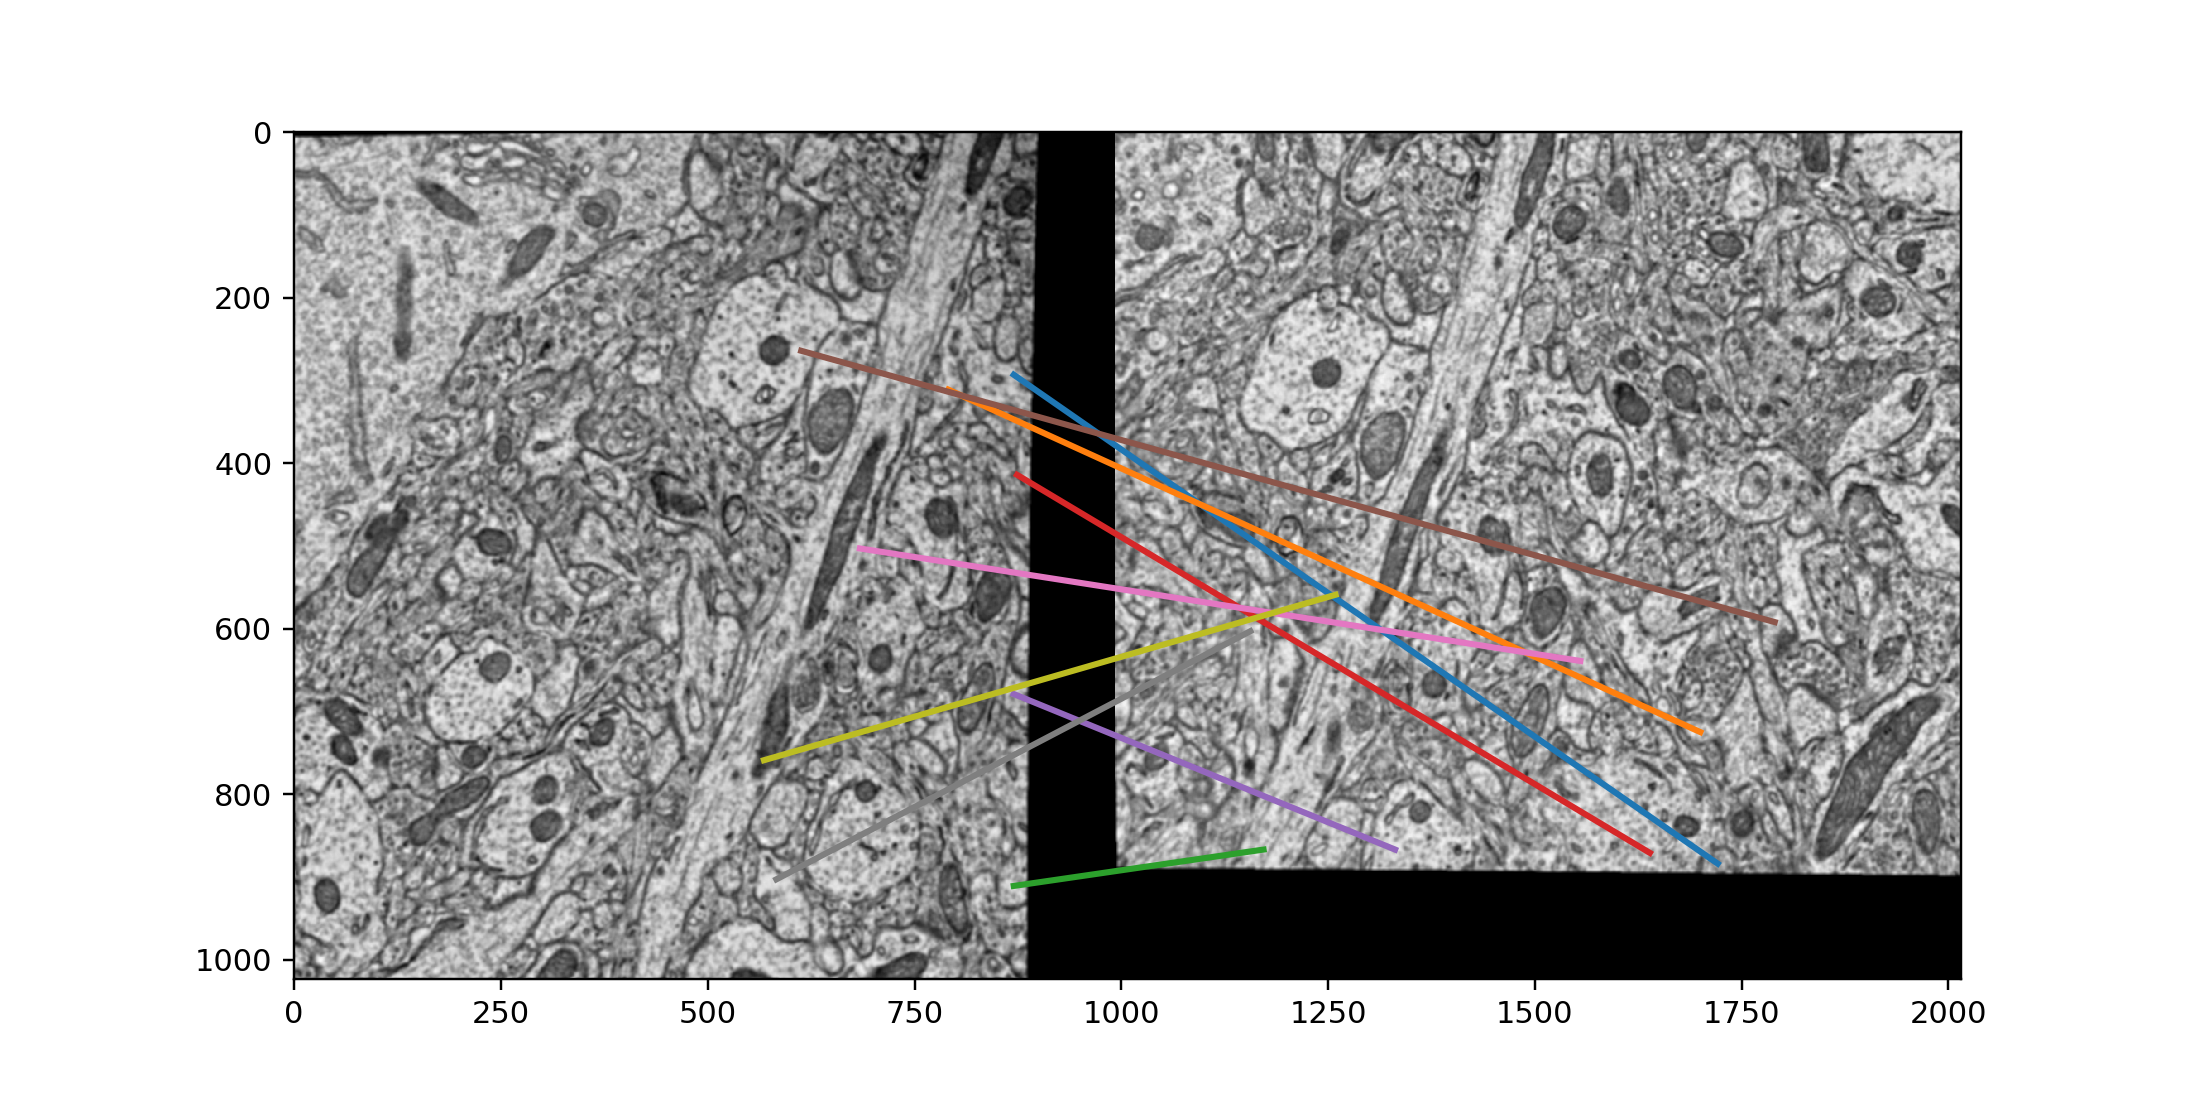

In [260]:
draw_matches(img1,kp1,img2,kp2,matches[inlierIdx])

In [106]:
inlierIdx

array([175,  82,  12,   3, 174, 194, 188,  27, 168,   9, 195, 173,  11,
       187,   0,   8, 171,  14,  68,   7,  13, 189,  83, 181, 182])

In [37]:
matches=np.array(matches)

In [39]:
matches[inlierIdx]

array([<DMatch 0x7f735bd635f0>, <DMatch 0x7f735bd63550>,
       <DMatch 0x7f735bd63270>, <DMatch 0x7f735bd63610>,
       <DMatch 0x7f735bd63510>, <DMatch 0x7f735bd63350>,
       <DMatch 0x7f735bd63530>, <DMatch 0x7f735bd63290>,
       <DMatch 0x7f735bd63370>], dtype=object)

In [189]:
len(kp2)

471